# Fig 3A: Alpha diversity plot

In [1]:
# import Python packages
import biom
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as ss
import seaborn as sns
import skbio
from skbio.diversity import alpha_diversity
from skbio.stats.distance import permanova
from skbio.stats.ordination import OrdinationResults
from skbio import DistanceMatrix
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from numpy import array
from numpy.random import RandomState

In [2]:
# read in biom table
biom_tbl = biom.load_table("../data/table.filt.zebra10.overlap.biom")
biom_tbl = biom_tbl.to_dataframe().T 

# convert data to array for rarefaction
data_arr = array(biom_tbl) 

In [3]:
# rarefy array table (rarefaction adjusts for differences in library sizes across samples to aid comparisons of alpha diversity) 

#find min sampling depth
sampling_depth_tbl = pd.DataFrame(index = biom_tbl.index)
sampling_depth_tbl['sampling_depth'] = biom_tbl.sum(axis = 1)
sampling_depth_sorted_tbl = sampling_depth_tbl.sort_values(by='sampling_depth', ascending = False)
min_depth = int(min(sampling_depth_sorted_tbl['sampling_depth']))

# rarefaction function
def rarefaction(M, seed=42):
    prng = RandomState(seed) # reproducible results
    noccur = np.sum(M, axis=1) # number of occurrences for each sample
    nvar = M.shape[1] # number of variables
    depth = min_depth

    Mrarefied = np.empty_like(M)
    for i in range(M.shape[0]): # for each sample
        p = M[i] / float(noccur[i]) # relative frequency / probability
        choice = prng.choice(nvar, depth, p=p)
        Mrarefied[i] = np.bincount(choice, minlength=nvar)

    return Mrarefied

# rarefy array table
data_arr_rare = rarefaction(data_arr)

In [4]:
# compute alpha diversity by shannon index
sample_ids = list(biom_tbl.index)
otu_ids = list(biom_tbl.columns)

alpha_shannon = alpha_diversity('shannon', data_arr_rare, ids = sample_ids) # calculate shannon diversity
alpha_shannon = pd.DataFrame(alpha_shannon, columns = ['shannon_index']) # convert to table 

alpha_shannon["mouse_type"] = "" # add column for mouse type
match_dict ={'Con' : 'Ctrl', 'Wound' : 'Wound', 'Vanco' : 'Vanco'} # create match dictionary
for key in match_dict:
    alpha_shannon.loc[alpha_shannon.index.str.contains(key, case=True), 'mouse_type'] = match_dict[key]

ctrl_alpha = alpha_shannon[alpha_shannon["mouse_type"] == "Ctrl"]["shannon_index"] # subset groups for boxplot 
wound_alpha = alpha_shannon[alpha_shannon["mouse_type"] == "Wound"]["shannon_index"]
vanco_alpha = alpha_shannon[alpha_shannon["mouse_type"] == "Vanco"]["shannon_index"]

In [5]:
# create color palette
my_colors = sns.set_palette(sns.color_palette(["#0000FF", "#FF0000", "#FFD700"])) 

mouse_types = ["Ctrl", "Wound", "Vanco"]
palette = dict(zip(
    mouse_types,
    sns.color_palette(my_colors, len(mouse_types))

))

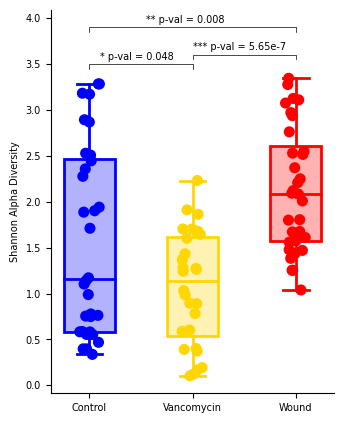

In [6]:
# create alpha diversity plot
mm = 1/25.4
fig, ax = plt.subplots(1, 1, figsize=(90*mm, 110*mm))

order = []
yticklabels = []

for i, (mouse_type, mouse_type_df) in enumerate(alpha_shannon.groupby("mouse_type")):
    color = palette[mouse_type]
    color2 = list(color) + [0.3]
    vals = mouse_type_df["shannon_index"]

    bp = ax.boxplot(
        vals,
        positions=[i],
        widths=0.5,
        vert=True,
        patch_artist=True
    )
    for element in ["boxes", "whiskers", "fliers", "medians", "caps"]:
        plt.setp(bp[element], color=color, lw=2)
    for box in bp["boxes"]:
        plt.setp(box, facecolor=color2, edgecolor=color)

    order.append(mouse_type)
#     yticklabels.append(f"{mouse_type} (n = {len(mouse_type_df)})")

sns.stripplot(
    data=alpha_shannon,
    y="shannon_index",
    x="mouse_type",
    ax=ax,
    order=order,
    palette=palette,
    hue="mouse_type",
    s=8,
)

ax.set_xlabel("")
ax.set_ylabel("Shannon Alpha Diversity", fontsize = 7)
plt.yticks(fontsize=7)

ax.plot([0, 0, 1, 1], [3.45, 3.5, 3.5, 3.45], linewidth=0.5, color='k')
ax.text(0.1, 3.55, '* p-val = 0.048', fontsize=7)
plt.plot([1, 1, 2, 2], [3.55, 3.6, 3.6, 3.55], linewidth=0.5, color='k')
ax.text(1.00, 3.65, '*** p-val = 5.65e-7', fontsize=7)
plt.plot([0, 0, 2, 2], [3.85, 3.9, 3.9, 3.85], linewidth=0.5, color='k')
ax.text(0.55, 3.95, '** p-val = 0.008', fontsize=7)

ax.set_xticklabels(["Control", 'Vancomycin', 'Wound'], fontsize = 7)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig("../plots/Fig_3A_alpha_diversity.png", dpi = 600)
plt.show()